In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

tf.get_logger().setLevel(logging.ERROR)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

Загрузим данные, разбив на тренировочную, валидационную и тестовую выборки:

In [4]:
train_ds, val_ds, test_ds = load_dataset(os.path.abspath('images'))

Found 19794 files belonging to 40 classes.
Using 13856 files for training.
Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим базовую модель Xception без верхних слоев:

In [6]:
base_model = tf.keras.applications.Xception(input_shape=(256, 256, 3),
                                            include_top=False,
                                            weights='imagenet')

Заморозим слои, чтобы веса не обновлялись во время обучения:

In [7]:
base_model.trainable = False

Определим архитектуру нашей модели:

In [8]:
inputs = tf.keras.Input(shape=(256, 256, 3))
preprocess =  tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(preprocess, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(40, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        10,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,396,304 (81.62 MB)

 Trainable params: 534,824 (2.04 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

Начнем обучение модели с замороженными нижними слоями:

In [10]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Определим наши коллбэк-функции:

In [11]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/xception.weights.h5",
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [12]:
%%time
history_1 = model.fit(train_ds,
                      epochs=20,
                      validation_data=val_ds,
                      callbacks=[checkpoint_cb, es])

Epoch 1/20


I0000 00:00:1713927869.390946   68941 service.cc:145] XLA service 0x7b29b8139380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713927869.390969   68941 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-24 10:04:29.513644: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-24 10:04:30.264504: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-04-24 10:04:36.352165: W external/local_tsl/tsl/framework/bfc_allocator.cc:368] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead.

  1/433 ━━━━━━━━━━━━━━━━━━━━ 1:40:28 14s/step - accuracy: 0.0625 - loss: 3.8185

I0000 00:00:1713927879.719998   68941 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.1832 - loss: 3.2205

2024-04-24 10:05:57.515203: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


433/433 ━━━━━━━━━━━━━━━━━━━━ 93s 183ms/step - accuracy: 0.1835 - loss: 3.2195 - val_accuracy: 0.4649 - val_loss: 2.0203
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 72s 166ms/step - accuracy: 0.4688 - loss: 1.9666 - val_accuracy: 0.5547 - val_loss: 1.6429
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 71s 164ms/step - accuracy: 0.5426 - loss: 1.6412 - val_accuracy: 0.5915 - val_loss: 1.4781
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 71s 163ms/step - accuracy: 0.5914 - loss: 1.4731 - val_accuracy: 0.6097 - val_loss: 1.3828
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 73s 167ms/step - accuracy: 0.6195 - loss: 1.3608 - val_accuracy: 0.6280 - val_loss: 1.3098
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 72s 167ms/step - accuracy: 0.6401 - loss: 1.2707 - val_accuracy: 0.6398 - val_loss: 1.2604
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 72s 165ms/step - accuracy: 0.6494 - loss: 1.2108 - val_accuracy: 0.6523 - val_loss: 1.2166
Epoch 8/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 71s 164ms/step - accuracy: 0.6717 - loss: 1.1567 - val

Так как число параметров в нижних слоях огромно (более 20 миллионов), то мы не будем размораживать \
нижние слои для тренировки в силу ограниченных вычислительных мощностей.

In [13]:
results = model.evaluate(test_ds)

93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.7353 - loss: 0.9495


In [14]:
results

[0.9838487505912781, 0.7321908473968506]

Посмотрим несколько предсказаний:

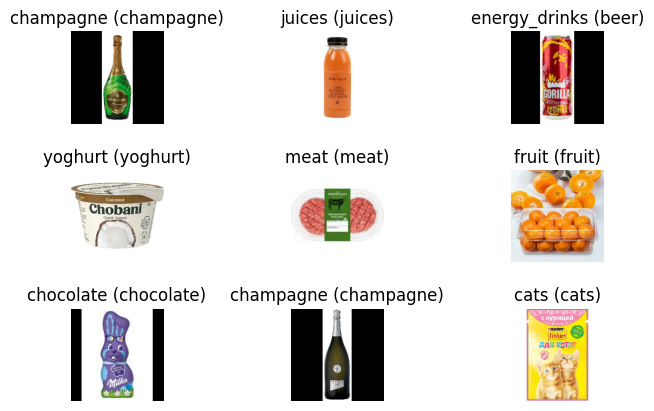

In [15]:
class_names = train_ds.class_names
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)


2024-04-24 10:42:12.708665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


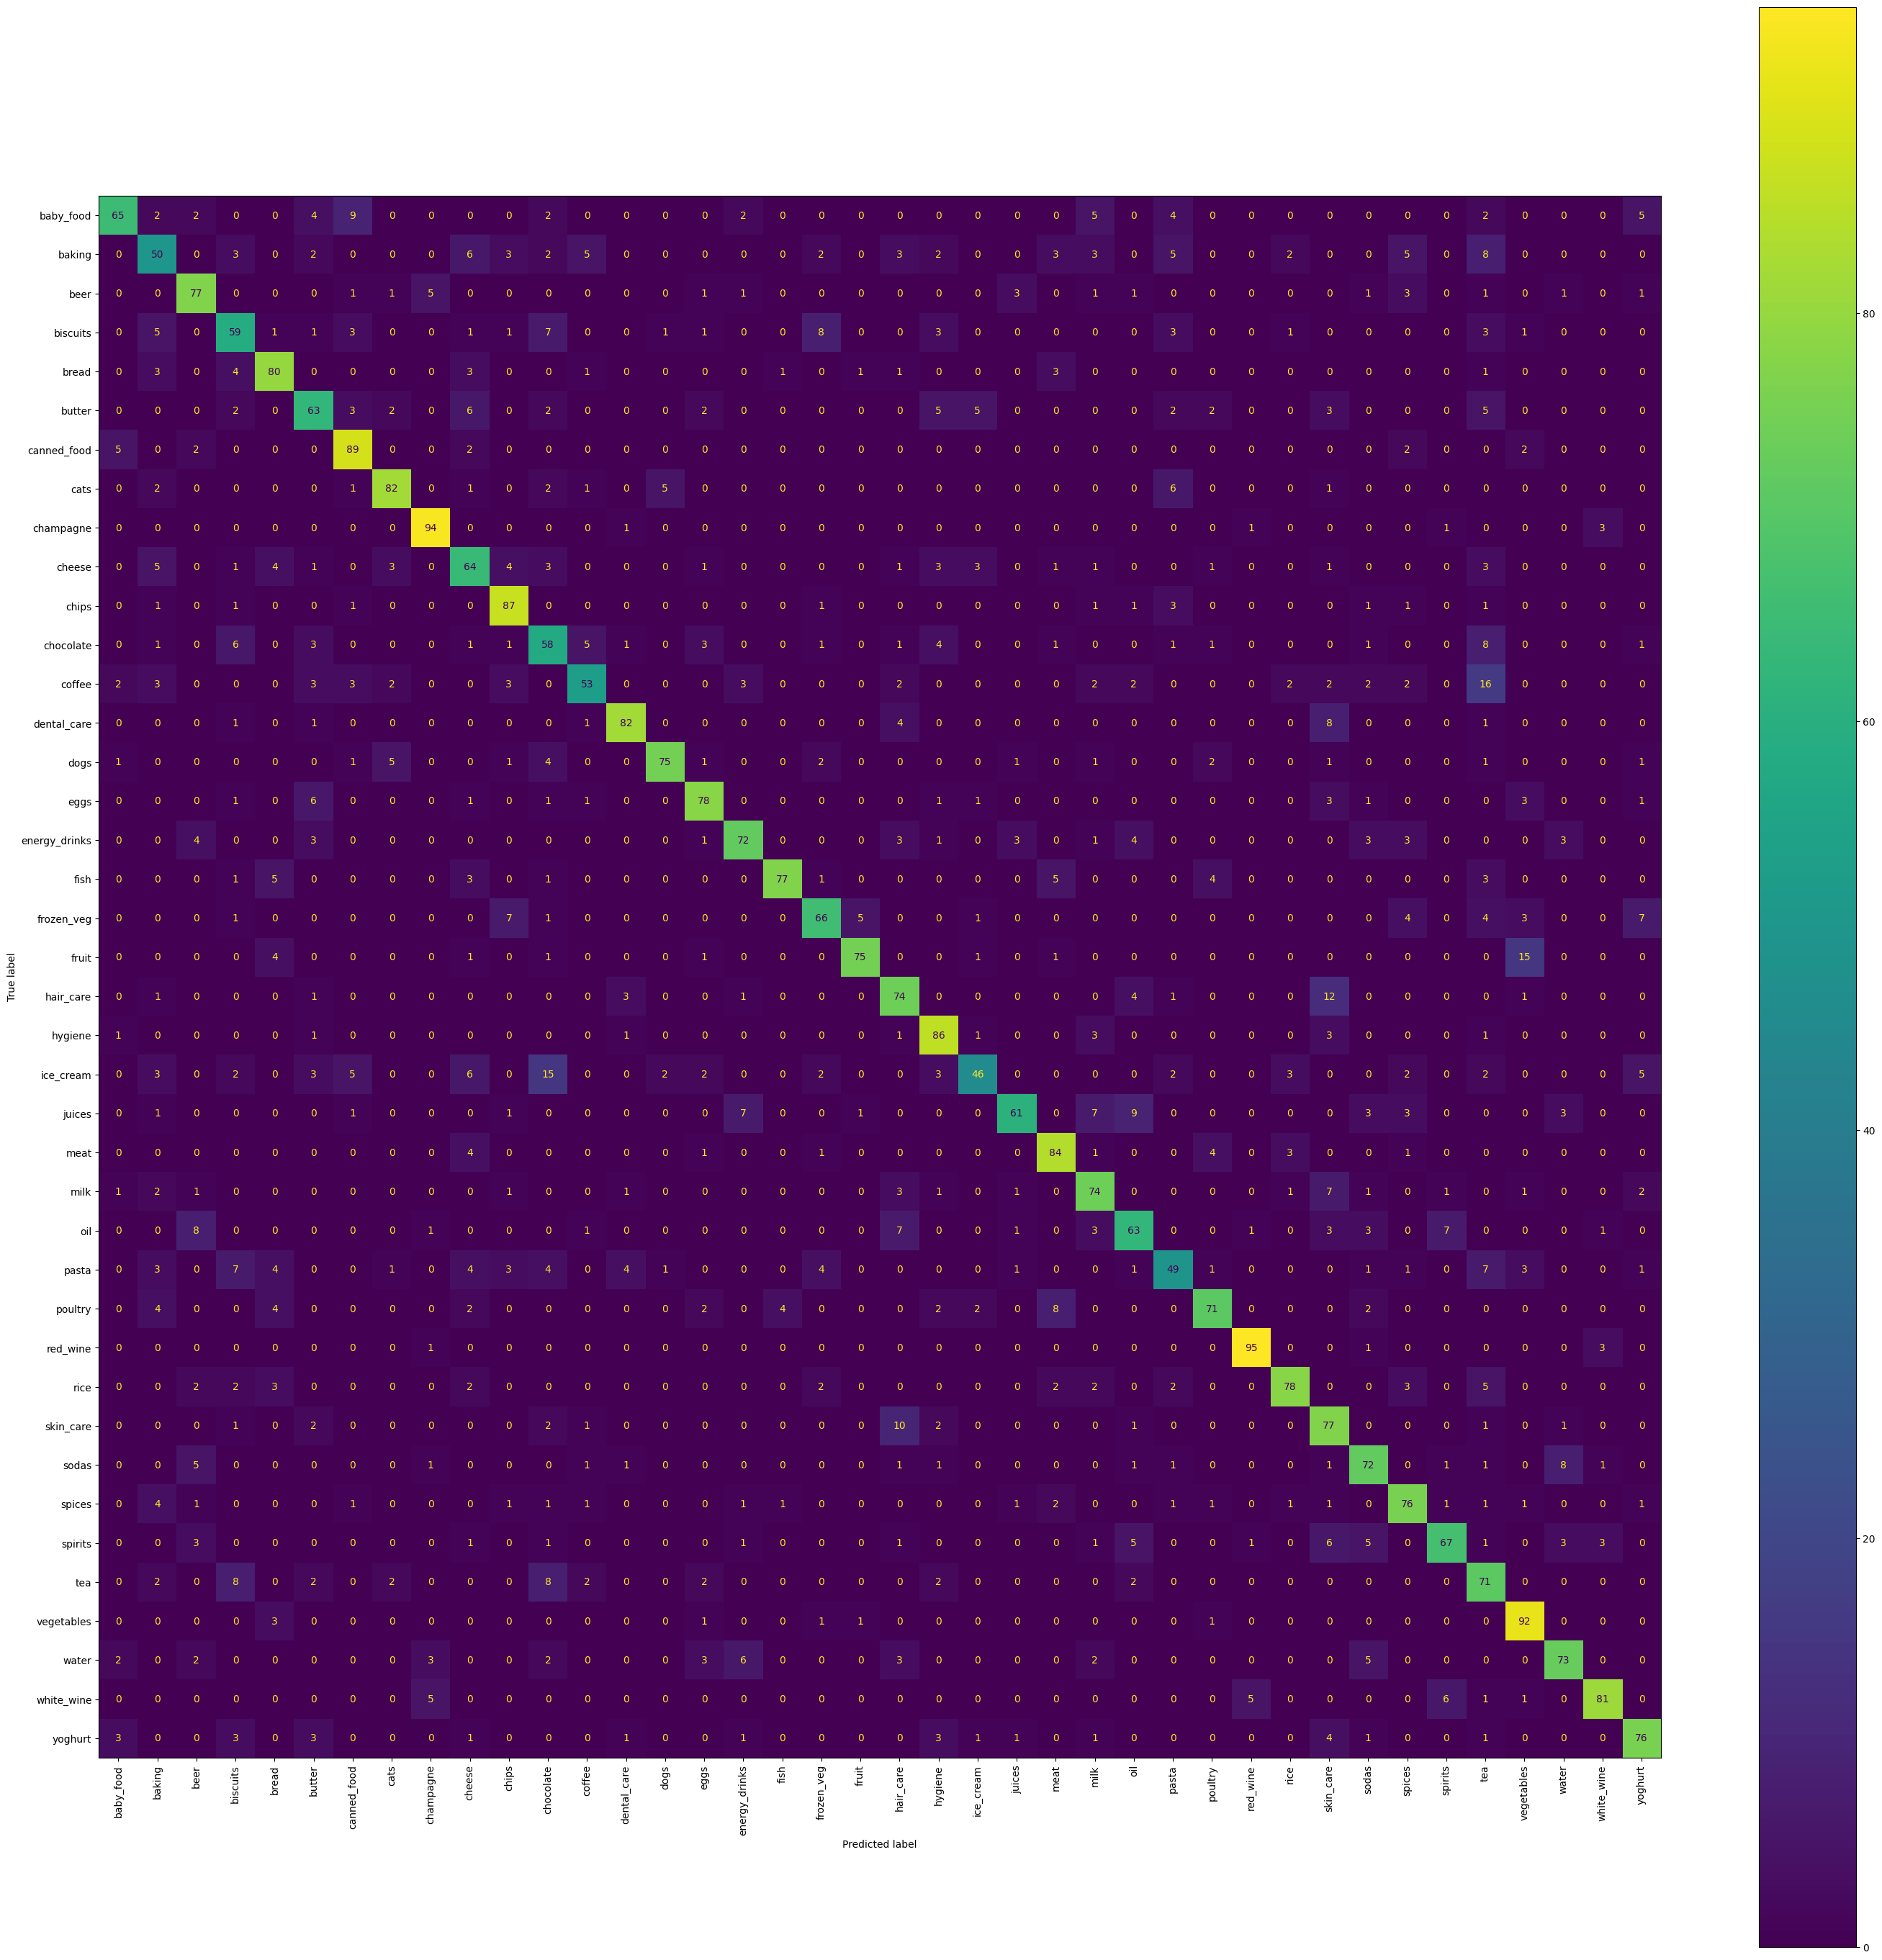

In [16]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

In [17]:
model.save('ready_models/xception.keras')

In [18]:
import json

with open('models_histories/xception.json', 'w') as f:
    json.dump(history_1.history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

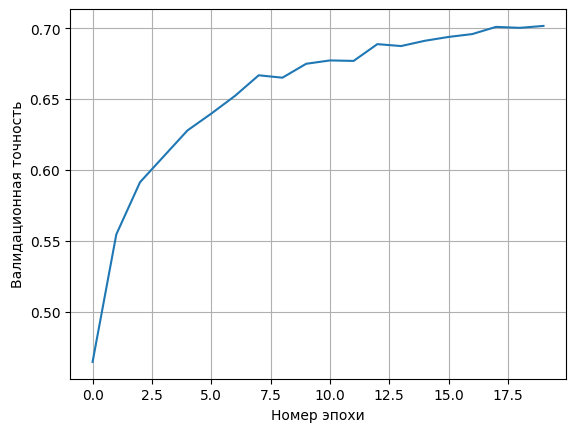

In [19]:
plt.plot(range(len(history_1.history['accuracy'])), history_1.history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')